# Feature Engineering and Modeling

The goal of the project is to predict house prices based on a set of numerical and categorical predictors. 
- After conducting Exploratory Data Analysis, cleaning, and preprocessing on the data, we will create a baseline regression model using only the numerical features.
- Next, we will convert the categorical features to numerical values using a mapping technique for ordinal features and OneHotEncoder for others. We will then perform feature engineering on all numerical values to improve our model's performance.
- To further enhance our model's performance, we will create a larger dataset by including additional engineered features. However, this may result in overfitting. Therefore, we will utilize normalization techniques to reduce the overfitting.
- Finally, we will evaluate which model performs better in predicting the target variable using the test data.

## Contents:

- [Imports](#Imports)
- [Baseline Score](#Baseline-Score)
- [Tranforming Categorical Features](#Tranforming-Categorical-Features)
- [Correlation of all features with Target](#Correlation-of-all-features-with-Target)
- [Linear Model](#Linear-Model)
- [LINEM Assumptions](#LINEM-Assumptions)
- [Feature Engineering](#Feature-Engineering)
- [Polynomial Features](#Polynomial-Features)
- [Normalization with Ridge and Lasso](#Normalization-with-Ridge-and-Lasso)
- [Save Models](#Save-Models)
- [Feature Engineering and Modeling Summary](#Feature-Engineering-and-Modeling-Summary)

## Imports

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer

from sklearn import metrics

pd.set_option("display.max_colwidth", None)

### Load Dataset

In [59]:
train_path = "../data/cleaned_dataset.csv"

In [60]:
# Load dataset and make a datframe based on that
df = pd.read_csv(train_path).drop("Unnamed: 0", axis=1)

In [61]:
# Get some basic information of our dataframe
print(f"Sample Data :{df.head()}")
print(f"\n--------------------------\n\n Columns : {[i for i in df.columns]}")
print(f"\n--------------------------\n\n Size of the dataset : {df.shape[0]}")
print(f"\n--------------------------\n\n Total number of features : {df.shape[1]}")
print(f"\n--------------------------\n\n Number of numerical features: {df.select_dtypes(include=[int, float]).shape[1]}")
print(f"\n--------------------------\n\n Number of categorical features: {df.select_dtypes(include=[object]).shape[1]}")

Sample Data :    Id        PID  MS SubClass MS Zoning  Lot Area Lot Shape Lot Config  \
0  109  533352170           60        RL     13517       IR1    CulDSac   
1  544  531379050           60        RL     11492       IR1    CulDSac   
2  153  535304180           20        RL      7922       Reg     Inside   
3  318  916386060           60        RL      9802       Reg     Inside   
4  255  906425045           50        RL     14235       IR1     Inside   

  Neighborhood Condition 1 Bldg Type  ... Garage Area  Paved Drive  \
0       Sawyer        RRAe      1Fam  ...       475.0            Y   
1  Sawyer West        Norm      1Fam  ...       559.0            Y   
2   North Ames        Norm      1Fam  ...       246.0            Y   
3   Timberland        Norm      1Fam  ...       400.0            Y   
4  Sawyer West        Norm      1Fam  ...       484.0            N   

   Wood Deck SF  Open Porch SF  Enclosed Porch Screen Porch Mo Sold Yr Sold  \
0             0             44      

In [62]:
# Define numerical values
# We don't need "PID" and "Id" because they can't be considered as impactful features on our target
# We drop "SalePrice" because it's our target and we just want to have our features
num = df.select_dtypes(include = [int, float]).drop(columns=["Id", "PID", "SalePrice"], axis=1)
num.columns

Index(['MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch',
       'Mo Sold', 'Yr Sold'],
      dtype='object')

## Baseline Score

In this step, we will calculate a baseline score for our linear regression model using only the numerical features in our dataset. we will use cross-validation with 5 folds to estimate the performance of our model. 

This baseline score will give you a starting point to compare the performance of our model with other models that we will build using different feature subsets or feature engineering techniques. We will use it to evaluate whether the new models are improved upon the baseline score or not.

#### Assemble Predictor Features (X) and Target (y) 

In [63]:
# Define X (features)
# We don't need "PID" and "Id" because they can't be considered as impactful features on our target
X = df.select_dtypes(include = [int, float]).drop(columns=["Id", "PID", "SalePrice"], axis=1)

# Define y (target)
y= df["SalePrice"]

print(f"The shape of X -------------- {X.shape}")
print(f"The shape of y -------------- {y.shape}")

The shape of X -------------- (1984, 31)
The shape of y -------------- (1984,)


In [64]:
# Instantiate Linear Regression Model
lr = LinearRegression()

In [65]:
# Utilize cross_val_score for getting baseline score
print(f"Our Baseline Score for predicting house pricing is ----------------- {np.mean(cross_val_score(lr, X, y, cv=5))}")

Our Baseline Score for predicting house pricing is ----------------- 0.8788177396266779


## Tranforming Categorical Features 
Categorical variables are non-numeric data types that represent discrete values. In order to use these variables in our models, we need to convert them into numeric form.

One way to do this is through one-hot encoding, which involves creating a new binary feature for each unique value of a categorical variable. In this case, Each feature would take the value 1 if the original value matches that feature, and 0 otherwise.

Another way to transform categorical variables is through ordinal encoding, which involves assigning a unique integer to each unique value of a categorical variable. 

By transforming categorical variables to numeric form, we can enable our models to use them as predictors and make more accurate predictions.

In [66]:
# Define equivalent values
rate_qual = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

# Columns for mapping
col_map = ["Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Heating QC", "Kitchen Qual"]

# Make for loop for executing map on columns
for column in col_map:
    df[column] = df[column].replace(to_replace=rate_qual)

In [67]:
# Map values in Basement Exposure with map function
df["Bsmt Exposure"] = df["Bsmt Exposure"].map({"None": 0, "Mn": 1, "Av": 2, "Gd":3})

In [68]:
# Map values in Central Air with map function
df["Central Air"] = df["Central Air"].map({"Y": 1, "N": 0})

In [69]:
# Check the remaining categorical features
df.select_dtypes(include="object").columns

Index(['MS Zoning', 'Lot Shape', 'Lot Config', 'Neighborhood', 'Condition 1',
       'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Electrical', 'Garage Type', 'Garage Finish',
       'Paved Drive', 'Sale Type'],
      dtype='object')

In [70]:
# Dummify all remaining categorical features
df_allnum = pd.get_dummies(df, drop_first=True)

print(f"number of all features after preprocessing: {df_allnum.shape[1]}")

number of all features after preprocessing: 151


In [71]:
# Save the preprocessed numerical dataset
df_allnum.to_csv("../data/all_numeric_dataset.csv")

## Correlation of all features with Target

After transforming all categorical features to numeric, by visualizing the correlation between each predictor and the target variable, we can identify which features have the strongest relationship with the target and may be good predictors in your machine learning model.

In [72]:
# correlation of target (SalePrice) with it's predictors 
saleprice_corr = df_allnum.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)

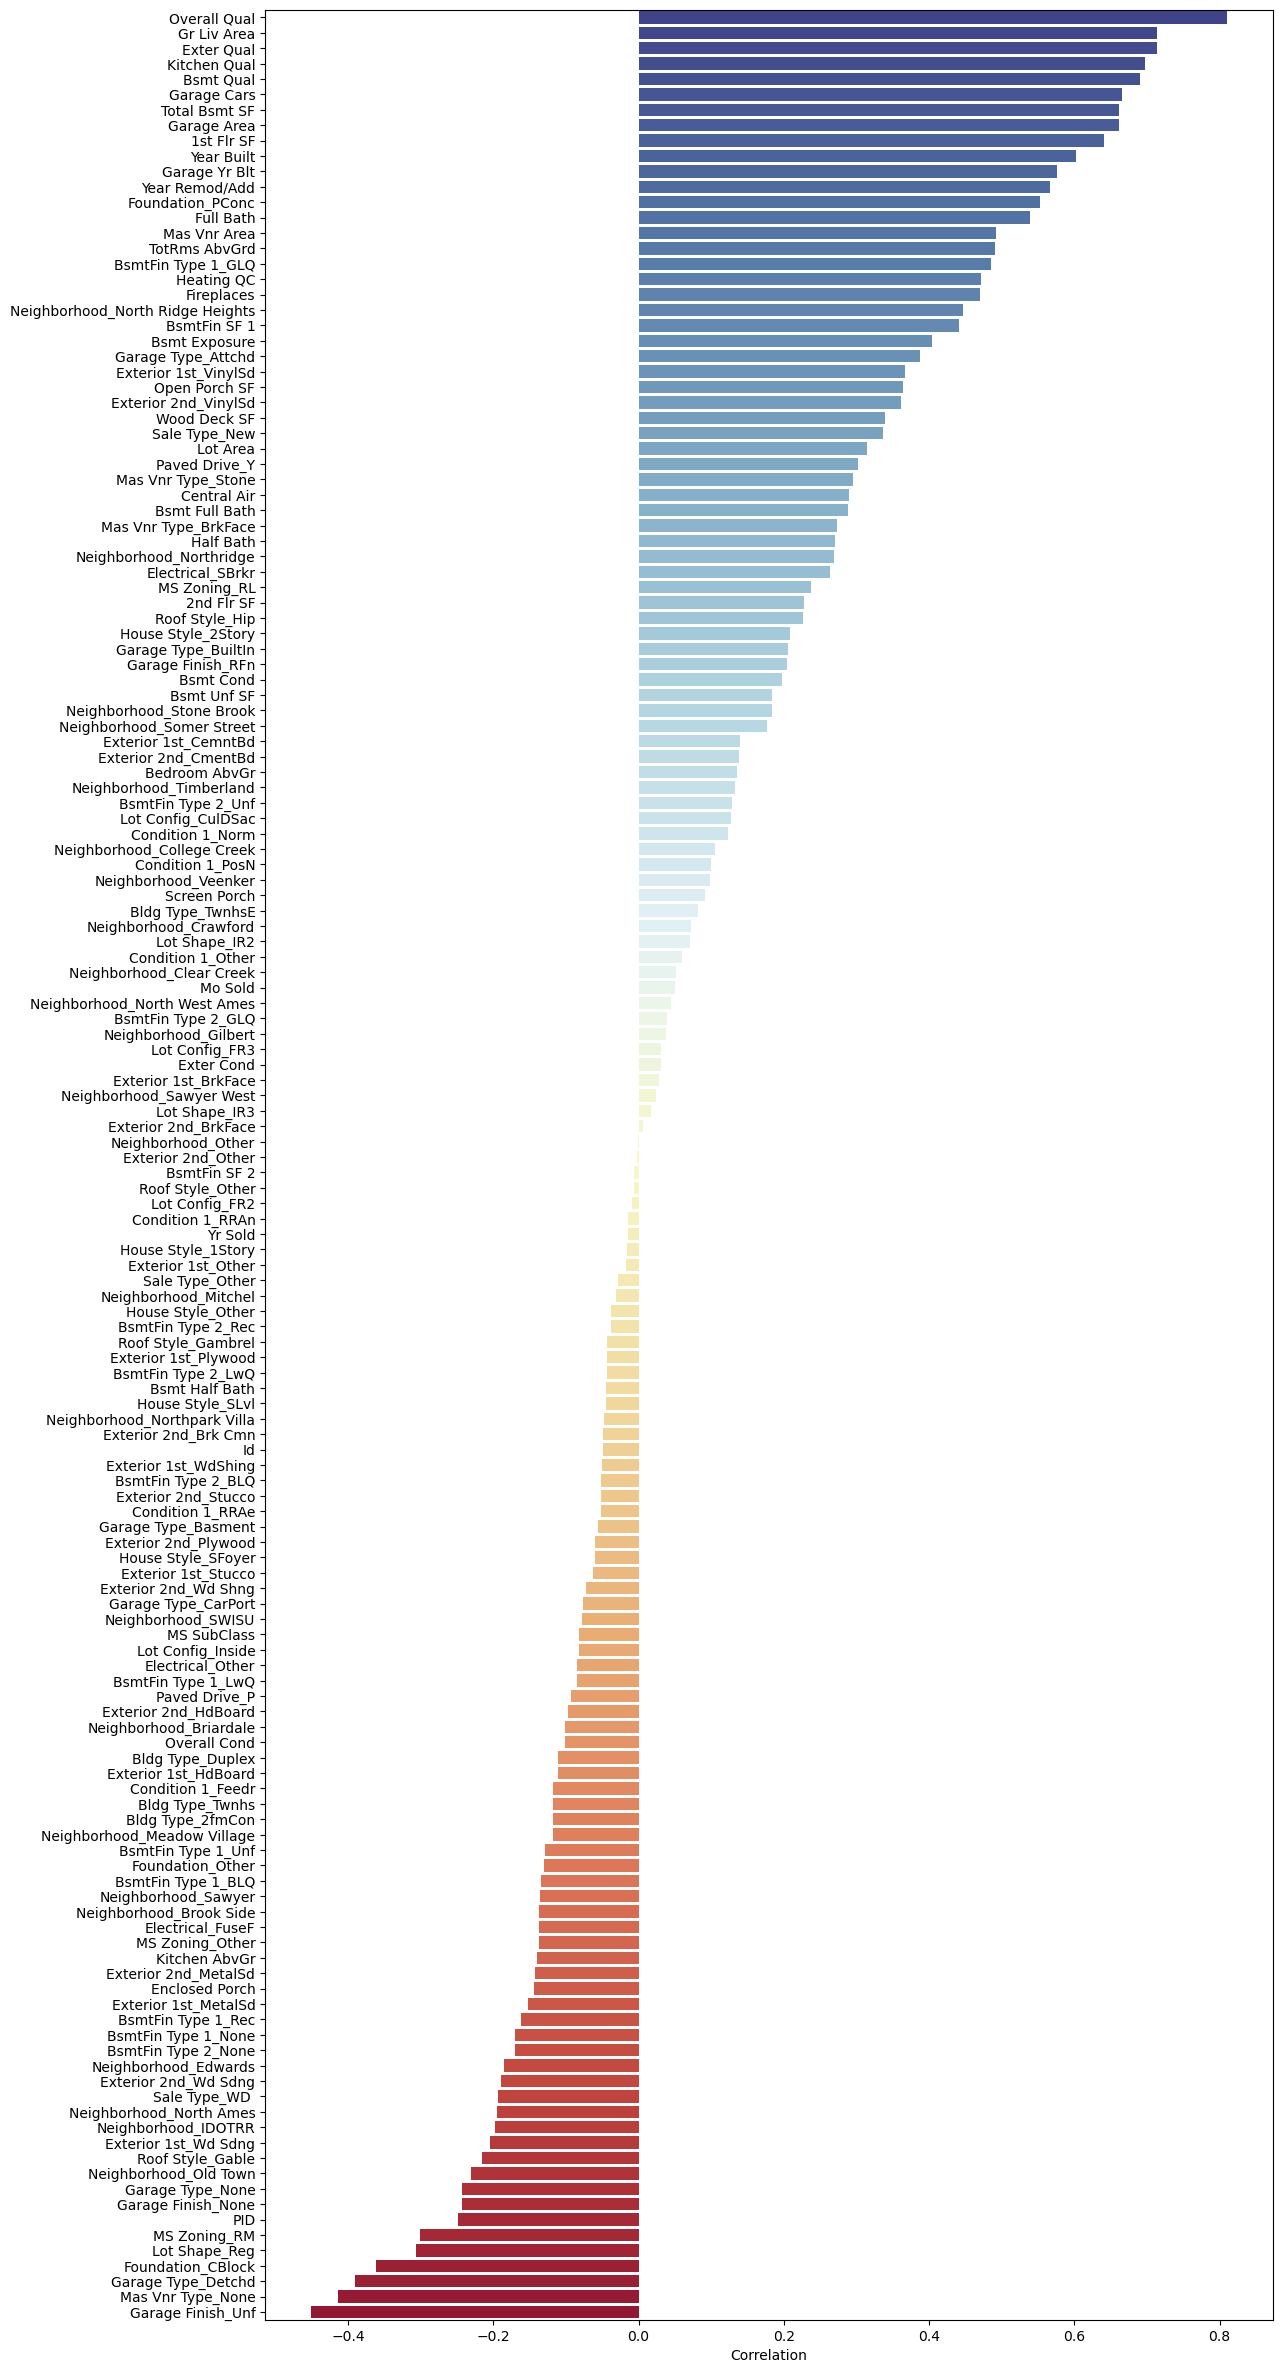

In [73]:
# Plot the correlation of all numerical features with target after preprocessing
palette_reverse = sns.color_palette("RdYlBu", n_colors=saleprice_corr.shape[0]-1)
palette_reverse.reverse()

plt.figure(figsize=(13, 30))
sns.barplot(x=saleprice_corr["SalePrice"][1:].values,
           y=saleprice_corr["SalePrice"][1:].index,
           palette=palette_reverse);
plt.title("")
plt.xlabel("Correlation");

#plt.subplots_adjust(left=0.4, right=0.9, top=0.95, bottom=0.05)

# Maximize the plot window
#manager = plt.get_current_fig_manager()
#manager.window.showMaximized()

# Display the plot
#plt.show()

## Linear Model
In this step, we will build a linear regression model using all the available features in your dataset. This model assumes a linear relationship between the predictor variables and the target variable (Sale Price). By using all available features, we can capture all possible relationships between the predictor variables and the target variable.

Then we will split our dataset into training and testing sets, fit the linear regression model on the training set, and then will evaluate the model's performance on the testing set. We will use metrics such as mean squared error (MSE), Root mean Squered (RMSE) and R-squared to evaluate the model's performance.

In [74]:
# Define X (features)
# We don't need "PID" and "Id" because they can't be considered as impactful features on our target 
X = df_allnum.drop(columns=["Id", "PID", "SalePrice"], axis=1)
y = df_allnum["SalePrice"]

print(f"The shape of X -------------- {X.shape}")
print(f"The shape of y -------------- {y.shape}")

The shape of X -------------- (1984, 148)
The shape of y -------------- (1984,)


### Train-Test Split

In [75]:
# Train-Test split on X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [76]:
# Instansiate the model and fit that on train data
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [77]:
# Predit the target based on test data
y_hat = model.predict(X_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the model
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Linear Regression Model ".center(34, "="))
print(f"Train R2 score: {model.score(X_train, y_train)}")
print(f"Test R2 score : {model.score(X_test, y_test)}")
print(f"MSE:            {mse}")
print(f"RMSE:           {rmse}")

==== Linear Regression Model =====
Train R2 score: 0.930390133331485
Test R2 score : 0.9212835024345513
MSE:            421685876.9387207
RMSE:           20534.991525167978


## LINEM Assumptions
LINEM assumptions, which stand for Linearity, Independence of errors, Normality of residuals, Equal variance of residuals (homoscedasticity), and Independence of predictors (no multicollinearity), are important assumptions in multiple linear regression analysis. These assumptions are necessary to ensure the validity and reliability of the regression model and its interpretations. In the following we will one by one check our assumptions:

**L :** There is a linear relationship between the independent variable(s) and the dependent variable. (Here will check one of the Xs to see its linear relationship with our target y)

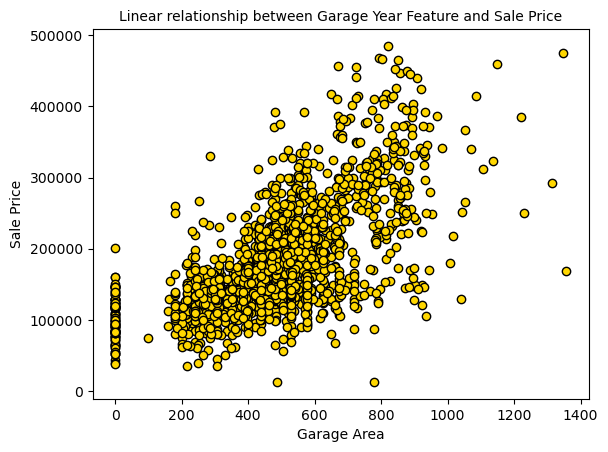

In [102]:
# Plot the scatter between Garage Area and Sale Price Target
plt.scatter(X["Garage Area"], y, color="gold", edgecolors="black")
plt.title("Linear Relationship Between Garage Year Feature and Sale Price", fontsize=10)
plt.xlabel("Garage Area", fontsize=10)
plt.ylabel("Sale Price", fontsize=10);

**I:** All the errors are independent; to check plot the residuals versus the time periods.  
Assumed, although this is probabily violated since this is time-series data.

N: All the variables are normally distributed; to check, plot a histogram of the residuals.

''

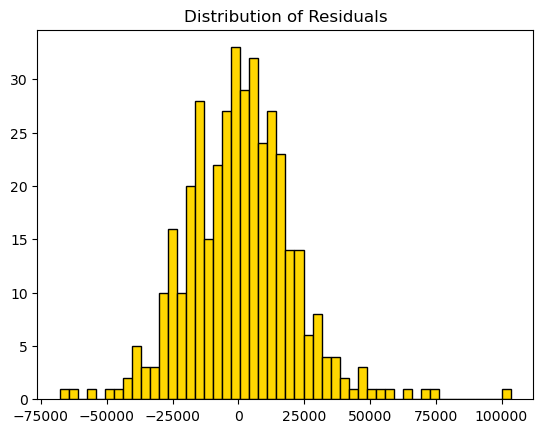

In [105]:
# Findout the errors
resids = y_test - y_hat

# Plot the distribution of errors
plt.hist(resids, bins=50, color="gold", edgecolor="black")
plt.title("Distribution of Residuals", fontsize=12)
;

**E:** The variance of errors is constant across all levels of the independent variable, this is called homoscedasticity; to check plot the residuals versus the predicted values of y.

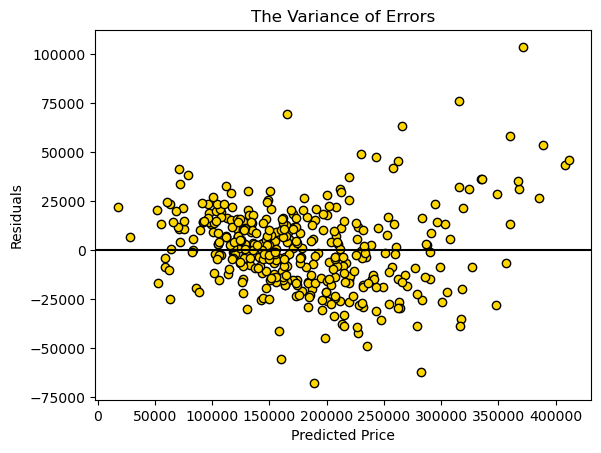

In [108]:
# Plot the scatter between predicted prices and errors
plt.scatter(y_hat, resids, color="gold", edgecolors="black")
plt.axhline(0, color="black")
plt.title("The Variance of Errors", fontsize=12)
plt.xlabel("Predicted Price", fontsize=10)
plt.ylabel("Residuals", fontsize=10);

**M:** No Multicollinearity/Independence of Predictors. The independent variables are all linearly independent (no variable dependents of the other variables); to check plot the independent values against each other and look for a correlation.

In [109]:
# Make table of correlations between features
X.corr()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,...,Garage Type_Detchd,Garage Type_None,Garage Finish_None,Garage Finish_RFn,Garage Finish_Unf,Paved Drive_P,Paved Drive_Y,Sale Type_New,Sale Type_Other,Sale Type_WD
MS SubClass,1.000000,-0.315126,0.046293,-0.072911,0.045031,0.048117,0.006409,0.034654,-0.055716,0.087496,...,0.048618,0.098179,0.098179,-0.053368,-0.024848,-0.036365,0.000104,-0.050841,0.008469,0.060800
Lot Area,-0.315126,1.000000,0.081118,-0.033859,0.034726,0.018930,0.096677,0.052608,0.027700,0.093124,...,-0.194830,-0.105242,-0.105242,0.044760,-0.065515,0.031902,-0.029506,0.014435,0.003610,-0.010130
Overall Qual,0.046293,0.081118,1.000000,-0.083588,0.611061,0.582656,0.417590,0.730389,0.008127,0.673180,...,-0.343522,-0.248424,-0.248424,0.217638,-0.431450,-0.090133,0.322959,0.311732,-0.043251,-0.176192
Overall Cond,-0.072911,-0.033859,-0.083588,1.000000,-0.365963,0.044165,-0.121680,-0.159000,0.413817,-0.267066,...,0.193267,-0.029874,-0.029874,-0.079433,0.209760,0.041164,-0.021007,-0.138293,-0.038475,0.157231
Year Built,0.045031,0.034726,0.611061,-0.365963,1.000000,0.630907,0.323798,0.625017,-0.081672,0.738800,...,-0.493498,-0.232835,-0.232835,0.300634,-0.520765,-0.164120,0.449158,0.327861,-0.046812,-0.192577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paved Drive_P,-0.036365,0.031902,-0.090133,0.041164,-0.164120,-0.134275,-0.067570,-0.096446,-0.022586,-0.102625,...,0.109499,0.017027,0.017027,-0.055710,0.090541,1.000000,-0.437067,-0.039530,-0.021288,0.031532
Paved Drive_Y,0.000104,-0.029506,0.322959,-0.021007,0.449158,0.242539,0.175948,0.229725,0.107223,0.274333,...,-0.221381,-0.324626,-0.324626,0.163515,-0.148735,-0.437067,1.000000,0.090443,-0.044660,-0.044499
Sale Type_New,-0.050841,0.014435,0.311732,-0.138293,0.327861,0.307228,0.110948,0.366553,-0.055427,0.334463,...,-0.150627,-0.048848,-0.048848,0.038626,-0.204287,-0.039530,0.090443,1.000000,-0.043094,-0.738262
Sale Type_Other,0.008469,0.003610,-0.043251,-0.038475,-0.046812,-0.055836,-0.027673,-0.046315,-0.026306,-0.040036,...,0.040472,0.025389,0.025389,0.023708,0.015239,-0.021288,-0.044660,-0.043094,1.000000,-0.397579


## Feature Engineering

After cleaning and preprocessing our data and creating initial regression models, we will perform feature engineering to see if we can further improve our model's performance. In this case, we will create new features based on the sum of other features and utilize PolynomialFeature engineering.

- To create new features based on the sum of other features, we will add together pairs of features that we believe the result may have a strong relationship with the target variable. 
- We will also utilize PolynomialFeature engineering to create new features that capture nonlinear relationships between the predictors and the target variable. This technique involves creating polynomial terms of existing features, such as squared or cubed terms. Here we will only consider squered term.

By creating new features based on the sum of other features and utilizing PolynomialFeature engineering, we hope to capture more complex relationships between the predictors and the target variable, and improve the accuracy and generalizability of our regression models.

### Make House Area Feature
We have features related to house area, including "Total Bsmt SF"(which is the sum of "BsmtFin SF 1", "BsmtFin SF 2" and "Bsmt Unf SF") and "Gr Liv Area" (which is the sum of "1st Flr SF" and "2nd Flr SF"), but we don't have a feature that represents the total house area. We can create a new feature that combines these areas by adding "Gr Liv Area" to "Total Bsmt SF". This will give us a better representation of the overall size of the house and may improve our model's predictive power.

In [110]:
# Make a new feature "House Area"
df_allnum["House Area"] = df_allnum["Total Bsmt SF"] + df_allnum["Gr Liv Area"]
print(f"The correlation between 'Total Bsmt SF' and 'SalePrice' ------------------------- {df_allnum['Total Bsmt SF'].corr(df_allnum['SalePrice'])}")
print(f"The correlation between 'Gr Liv Area' and 'SalePrice' --------------------------- {df_allnum['Gr Liv Area'].corr(df_allnum['SalePrice'])}\n")

print(f"The correlation between engineered feature 'House Area' and 'SalePrice' --------- {df_allnum['House Area'].corr(df_allnum['SalePrice'])}")

The correlation between 'Total Bsmt SF' and 'SalePrice' ------------------------- 0.6616820843901062
The correlation between 'Gr Liv Area' and 'SalePrice' --------------------------- 0.7143736650819272

The correlation between engineered feature 'House Area' and 'SalePrice' --------- 0.8238124091004698


### Make Total Bathroom Feature
We will create three new features based on the bathroom features in our dataset: :
- "Bsmt Full_Half Bath" to represent the total number of bathrooms in the basement
- "Full_Half Bath" to represent the total number of above-ground bathrooms
- and "Total Full_Half Bath" to represent the total number of bathrooms in the house
These features could be useful in our regression model to predict the house prices more accurately.

In [111]:
# Make a new feature as a basement full-half bath which is the sum of basement full bath and basement half bath
df_allnum["Bsmt Full_Half Bath"] = df_allnum["Bsmt Full Bath"] + (df_allnum["Bsmt Half Bath"]/2)

# Make a new feature as above ground full-half bath which is the sum of above ground full bath and above ground half bath 
df_allnum["Full_Half Bath"] = df_allnum["Full Bath"] + (df_allnum["Half Bath"]/2)

# Make a new feature as a total full-half bath which is the sum of basement full-half bath and above ground full-half bath
df_allnum["Total Full_Half Bath"] = df_allnum["Bsmt Full_Half Bath"] + df_allnum["Full_Half Bath"]

print(f"The correlation between 'Bsmt Full Bath' and 'SalePrice' ---------------------------------- {df_allnum['Bsmt Full Bath'].corr(df_allnum['SalePrice'])}")
print(f"The correlation between 'Bsmt Half Bath' and 'SalePrice' ---------------------------------- {df_allnum['Bsmt Half Bath'].corr(df_allnum['SalePrice'])}")
print(f"The correlation between 'Full Bath' and 'SalePrice' --------------------------------------- {df_allnum['Full Bath'].corr(df_allnum['SalePrice'])}")
print(f"The correlation between 'Half Bath' and 'SalePrice' --------------------------------------- {df_allnum['Half Bath'].corr(df_allnum['SalePrice'])}\n")
print(f"The correlation between featured engineered 'Bsmt Full_Half Bath'and and 'SalePrice' ------ {df_allnum['Bsmt Full_Half Bath'].corr(df_allnum['SalePrice'])}")
print(f"The correlation between featured engineered 'Full_Half Bath' and 'SalePrice' -------------- {df_allnum['Full_Half Bath'].corr(df_allnum['SalePrice'])}")
print(f"The correlation between featured engineered 'Total Full_Half Bath' and 'SalePrice' -------- {df_allnum['Total Full_Half Bath'].corr(df_allnum['SalePrice'])}")

The correlation between 'Bsmt Full Bath' and 'SalePrice' ---------------------------------- 0.28867519608231285
The correlation between 'Bsmt Half Bath' and 'SalePrice' ---------------------------------- -0.04517267226064677
The correlation between 'Full Bath' and 'SalePrice' --------------------------------------- 0.5391059765624661
The correlation between 'Half Bath' and 'SalePrice' --------------------------------------- 0.27099751533079736

The correlation between featured engineered 'Bsmt Full_Half Bath'and and 'SalePrice' ------ 0.28089201203319236
The correlation between featured engineered 'Full_Half Bath' and 'SalePrice' -------------- 0.5738722031645553
The correlation between featured engineered 'Total Full_Half Bath' and 'SalePrice' -------- 0.6455633485575809


## Polynomial Features
By uttilizing PolynomialFeatures transformer, we will try to create new features that may be more informative than the original features, and can often help to improve model performance.

#### Create Polynomial Features by grouping together features that are related to the same subject.

In [112]:
# Make a list of features for PolynomialFeature transformation
pol_qualcond = ["Overall Qual", "Overall Cond"]
pol_builtremod = ["Year Built", "Year Remod/Add"]
pol_bsmtarea = ["Total Bsmt SF", "Bsmt Qual", "Bsmt Cond"]
pol_levelsarea = ["1st Flr SF", "2nd Flr SF", "Gr Liv Area"]
pol_area = ["House Area", "Gr Liv Area", "Total Bsmt SF"]
pol_houselot = ["House Area", "Lot Area"]
pol_bath = ["Bsmt Full_Half Bath", "Full_Half Bath", "Total Full_Half Bath"]
pol_exter = ["Exter Qual", "Exter Cond"]
pol_kitchen = ["Kitchen AbvGr", "Kitchen Qual"]
pol_heatair = ["Heating QC", "Central Air"]
pol_garage = ["Garage Cars", "Garage Area"]
pol_sold = ["Mo Sold", "Yr Sold"]
pol_section = ["Bedroom AbvGr", "Kitchen AbvGr", "Full Bath", "Half Bath","TotRms AbvGrd"]
pol_yrbuilt = ["Year Built", "Garage Yr Blt"]

In [113]:
# Utilize ColumnTransformer to do a number of Ploy transformers together ("name", transformer, list of features)
ct = ColumnTransformer([
    ("pqual",PolynomialFeatures(include_bias=False), pol_qualcond),
    ("pbuilt", PolynomialFeatures(include_bias=False), pol_builtremod),
    ("pbsmtarea", PolynomialFeatures(include_bias=False), pol_bsmtarea),
    ("plarea", PolynomialFeatures(include_bias=False), pol_levelsarea),
    ("parea", PolynomialFeatures(include_bias=False), pol_area),
    ("phl", PolynomialFeatures(include_bias=False), pol_houselot),
    ("pbath", PolynomialFeatures(include_bias=False), pol_bath),
    ("pexter", PolynomialFeatures(include_bias=False), pol_exter),
    ("pkitch", PolynomialFeatures(include_bias=False), pol_kitchen),
    ("pheat", PolynomialFeatures(include_bias=False), pol_heatair),
    ("pgarage", PolynomialFeatures(include_bias=False), pol_garage),
    ("psold", PolynomialFeatures(include_bias=False), pol_sold),
    ("psec", PolynomialFeatures(include_bias=False), pol_section),
    ("pyearb", PolynomialFeatures(include_bias=False), pol_yrbuilt)
], remainder="passthrough")

In [114]:
# Redefine X (poly) and y 
X_poly = ct.fit_transform(df_allnum.drop(columns=["Id", "PID", "SalePrice"], axis=1))
y = df_allnum["SalePrice"]

# Train-Test Split 
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, random_state=42, test_size=0.2)

In [115]:
# Instantiate Linear regression model
model_poly = LinearRegression()

# Fit Linear regression model on train data
model_poly.fit(X_train_poly, y_train)

LinearRegression()

In [116]:
# Predict the target based on test data
y_hat = model_poly.predict(X_test_poly)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the model
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Model with Polynomial Features ".center(36, "="))
print(f"Train R2 score:  {model_poly.score(X_train_poly, y_train)}")
print(f"Test R2 score:   {model_poly.score(X_test_poly, y_test)}")
print(f"MSE:             {mse}")
print(f"RMSE:            {rmse}")

== Model with Polynomial Features ==
Train R2 score:  0.9447325400907205
Test R2 score:   0.9369854792828799
MSE:             337570067.90575826
RMSE:            18373.079978755828


### Create a Large Dataset with Polynomial Features of All Predictors
After applying the polynomial feature transformer on all of our features, we will end up with a large number of features, which may lead to overfitting. To avoid overfitting, we need to use normalization techniques to make the model more generalized. But, before applying normalization techniques we need to scale our data, which is necessary because our features have different scales.  
Scaling helps to ensure that all features are equally important during training, regardless of their initial scale. Without scaling, larger features may have a disproportionately greater impact on the model's prediction, which can lead to overfitting. Therefore, we will use standard scaling to scale our features, which involves transforming the data to have zero mean and unit variance.

In [29]:
# Instantiate our PolynomialFeatures object to create all two-way terms
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and transform our X data 
X_gig_poly = poly.fit_transform(df_allnum.drop(columns=["Id", "PID", "SalePrice"], axis=1))

# Define Target
y = df_allnum["SalePrice"]

# Train-Test Split
X_train_gig_poly, X_test_gig_poly, y_train, y_test = train_test_split(X_gig_poly, y, random_state=42, test_size=0.2)

# Scale our data
# Relabeling scaled data as "Z" 
sc = StandardScaler()
Z_train = sc.fit_transform(X_train_gig_poly)
Z_test = sc.transform(X_test_gig_poly)

#### Create an overfitted model using all features and polynomial features

In [30]:
# Instantiate Linear model
ols = LinearRegression()

# Fit the model on train data
ols.fit(Z_train, y_train)

LinearRegression()

In [33]:
# Predict the target based on test data
y_hat = ols.predict(Z_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the model
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Overfitted Model ".center(42, "="))
print(f"Train R2 score:          {ols.score(Z_train, y_train)}")
print(f"Test R2 score:           {ols.score(Z_test, y_test)}")
print(f"MSE:                     {mse}")
print(f"RMSE:                    {rmse}")

============ Overfitted Model ============
Train R2 score:          0.9999957845445793
Test R2 score:           -1.4758482802476657e+21
MSE:                     7.906149225799738e+30
RMSE:                    2811787549904818.0


## Normalization with Ridge and Lasso
After applying polynomial features and standard scaling on the training data, we observed that the model was extremely overfitted. This means that the model was performing very well on the training data but was not able to generalize well on the unseen data (test data).

To address this issue, we will employ Ridge and Lasso normalization techniques. Ridge and Lasso are regularization methods that add a penalty term to the loss function to shrink the coefficients of the predictors towards zero. However, there is a difference between them. Ridge regression adds a penalty term equivalent to the square of the magnitude of the coefficients, while Lasso regression adds a penalty term equivalent to the absolute magnitude of the coefficients.

Moreover, we utilized Ridge CV and Lasso CV techniques. Ridge CV and Lasso CV are similar to Ridge and Lasso, respectively, but they use cross-validation to find the best value of the regularization parameter alpha. This helps to select the optimal value of alpha, which balances the trade-off between the bias and variance of the model.

### 1. Normalizing with Ridge and Ridge CV

#### 1.1. Nomalizing with Ridge
The alpha parameter controls the strength of the penalty term in Ridge regression, with larger values of alpha resulting in stronger regularization.

In [36]:
# Instantiate Ridge model
ridge = Ridge(alpha=10)

# Fit the Ridge model on train data
ridge.fit(Z_train, y_train)

Ridge(alpha=10)

In [37]:
# Predict the target based on test data
y_hat = ridge.predict(Z_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the model
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Ridge Regression Model ".center(36, "="))
print(f"Train R2 score:            {ridge.score(Z_train, y_train)}")
print(f"Test R2 score:             {ridge.score(Z_test, y_test)}")
print(f"MSE:                       {mse}")
print(f"RMSE:                      {rmse}")

====== Ridge Regression Model ======
Train R2 score:            0.9991362040819793
Test R2 score:             0.8248551871127258
MSE:                       938254321.4937987
RMSE:                      30630.93732639925


#### 1.2. Nomalizing with Ridge CV
The alpha parameter controls the strength of the penalty term in Ridge regression, with larger values of alpha resulting in stronger regularization. The cv parameter specifies the number of folds to use in cross-validation. np.logspace(0, 3, 1000) is a function that generates an array of 1000 evenly spaced numbers on a logarithmic scale between 10^0 and 10^3

In [38]:
# Define the range of alphas
r_alphas = np.logspace(0, 3, 1000)

# Instantiate the Ridge CV model
ridge_cv = RidgeCV(alphas=r_alphas, scoring="r2", cv=5)

# Fit the model on train data
ridge_cv.fit(Z_train, y_train)

# The best alpha
ridge_cv.alpha_

1000.0

In [47]:
# Predict the target based on test data
y_hat = ridge_cv.predict(Z_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the data
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Ridge CV Regression Model ".center(36, "="))
print(f"Train R2 score:          {ridge_cv.score(Z_train, y_train)}")
print(f"Test R2 score:           {ridge_cv.score(Z_test, y_test)}")
print(f"MSE:                     {mse}")
print(f"RMSE:                    {rmse}")

==== Ridge CV Regression Model =====
Train R2 score:          0.9829503597003991
Test R2 score:           0.9328879499785775
MSE:                     359520615.6486912
RMSE:                    18961.028865773376


#### 2. Normalizing with Lasso and Lasso CV

#### 2.1. Normalizing with Lasso
Like Ridge the alpha parameter controls the strength of the penalty term in Lasso regression, with larger values of alpha resulting in stronger regularization.

In [48]:
# Instantiate Ridge model
lasso = Lasso(alpha=10)

# Fit the model on train data
lasso.fit(Z_train, y_train)

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.280e+10, tolerance: 8.438e+08
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=10)

In [49]:
# Predict the target based on test data
y_hat = lasso.predict(Z_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the model
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Lasso Regression Model ".center(36, "="))
print(f"Train R2 score:            {lasso.score(Z_train, y_train)}")
print(f"Test R2 score:             {lasso.score(Z_test, y_test)}")
print(f"MSE:                       {mse}")
print(f"RMSE:                      {rmse}")

====== Lasso Regression Model ======
Train R2 score:            0.9986661879563554
Test R2 score:             0.8216042542177957
MSE:                       955669635.0693003
RMSE:                      30913.906823132213


#### 2.2. Nomalizing with Lasso CV
The alpha parameter controls the strength of the penalty term in Lasso regression, with larger values of alpha resulting in stronger regularization. The cv parameter specifies the number of folds to use in cross-validation. n_jobs parameter speeds up the computation of the Lasso regression by distributing the work across multiple CPU cores. np.logspace(0, 3, 1000) is a function that generates an array of 1000 evenly spaced numbers on a logarithmic scale between 10^0 and 10^3.

In [50]:
# Define the range of alphas
r_alphas = np.logspace(0, 3, 1000)

# Instantiate the Ridge CV model
lasso_cv = LassoCV(alphas=r_alphas, n_jobs=4, cv=5)

# Fit the model on train data
lasso_cv.fit(Z_train, y_train)

# The best alpha
lasso_cv.alpha_

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.773e+08, tolerance: 6.601e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.681e+08, tolerance: 6.601e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

835.4528058382863

In [51]:
# Predict the target based on test data
y_hat = lasso_cv.predict(Z_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the data
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Lasso CV Regression Model ".center(38, "="))
print(f"Train R2 score:          {lasso_cv.score(Z_train, y_train)}")
print(f"Test R2 score:           {lasso_cv.score(Z_test, y_test)}")
print(f"MSE:                     {mse}")
print(f"RMSE:                    {rmse}")

===== Lasso CV Regression Model ======
Train R2 score:          0.9552014633967459
Test R2 score:           0.939143712833702
MSE:                     326008366.9197571
RMSE:                    18055.701784194298


#### Get to know features with highest and loest coefficients 

In [ ]:
# Make a dataframe based on X features and theire coefficient
#coef_df = pd.DataFrame({"Features": X_gig_poly.columns, "Coefficient": lasso_cv.coef_})

# Features with highest coefficients
#coef_df.sort_values("Coefficient", ascending=False).head()

In [ ]:
# Features with lowest coefficients
#coef_df.sort_values("Coefficient", ascending=False).tail()

In [56]:
# Predit the target based on test data
y_hat = model.predict(X_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the model
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Linear Regression Model ".center(38, "="))
print(f"Train R2 score:     {model.score(X_train, y_train)}")
print(f"Test R2 score :     {model.score(X_test, y_test)}")
print(f"MSE:                {mse}")
print(f"RMSE:               {rmse}")

# Predict the target based on test data
y_hat = model_poly.predict(X_test_poly)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the model
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Model with Polynomial Features ".center(38, "="))
print(f"Train R2 score:     {model_poly.score(X_train_poly, y_train)}")
print(f"Test R2 score:      {model_poly.score(X_test_poly, y_test)}")
print(f"MSE:                {mse}")
print(f"RMSE:               {rmse}")

# Predict the target based on test data
y_hat = ridge_cv.predict(Z_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the data
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Ridge CV Regression Model ".center(38, "="))
print(f"Train R2 score:     {ridge_cv.score(Z_train, y_train)}")
print(f"Test R2 score:      {ridge_cv.score(Z_test, y_test)}")
print(f"MSE:                {mse}")
print(f"RMSE:               {rmse}")

# Predict the target based on test data
y_hat = lasso_cv.predict(Z_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the data
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Lasso CV Regression Model ".center(38, "="))
print(f"Train R2 score:     {lasso_cv.score(Z_train, y_train)}")
print(f"Test R2 score:      {lasso_cv.score(Z_test, y_test)}")
print(f"MSE:                {mse}")
print(f"RMSE:               {rmse}")

====== Linear Regression Model =======
Train R2 score:     0.930390133331485
Test R2 score :     0.9212835024345513
MSE:                421685876.9387207
RMSE:               20534.991525167978
=== Model with Polynomial Features ===
Train R2 score:     0.9447325400907205
Test R2 score:      0.9369854792828799
MSE:                337570067.90575826
RMSE:               18373.079978755828
===== Ridge CV Regression Model ======
Train R2 score:     0.9829503597003991
Test R2 score:      0.9328879499785775
MSE:                359520615.6486912
RMSE:               18961.028865773376
===== Lasso CV Regression Model ======
Train R2 score:     0.9552014633967459
Test R2 score:      0.939143712833702
MSE:                326008366.9197571
RMSE:               18055.701784194298


## Save Models

In [59]:
with open("../models/regression_model.pkl", "wb") as pickle_out:
    pickle_out = pickle.dump(model, pickle_out)

with open("../models/poly_model.pkl", "wb") as pickle_out:
    pickle_out = pickle.dump(model_poly, pickle_out)   

with open("../models/ridge_regression_model.pkl", "wb") as pickle_out:
    pickle_out = pickle.dump(ridge_cv, pickle_out) 

with open("../models/lasso_regression_model.pkl", "wb") as pickle_out:
    pickle_out = pickle.dump(ridge_cv, pickle_out)

## Feature Engineering and Modeling Summary
- Transformed categorical features to numerical using mapping and one-hot encoding
- Created a linear model using all features
- Conducted feature engineering to create new features and improve model performance
- Utilized polynomial feature transformation on selected features to create new features with high correlation with the target variable and improve model performance
- Attempted to create polynomial features for all features, resulting in a large dataset and overfitting
- Utilized ridge and lasso normalization techniques to simplify the model and reduce overfitting

Overall, this process involves creating new features and transforming existing features to improve model performance, as well as utilizing normalization techniques to prevent overfitting and make the model simpler and more interpretable.